In [2]:
pip install --upgrade --force-reinstall tensorflow-gpu

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu (from versions: none)
ERROR: No matching distribution found for tensorflow-gpu
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
# from ddqn_keras import DDQNAgent
# from utils import plotLearning
from keras.layers import Dense, Activation
from keras.models import Sequential, load_model
from keras.optimizers import Adam


Using TensorFlow backend.


In [2]:
# Experience Replay
class ReplayBuffer():
    def __init__(self,memory_size=100000, input_shape=(9,)):
        self.memory_size = int(memory_size/1.5)
        self.input_shape = input_shape
        # memory counter -> tracks first unsaved memory and use it to insert new memory into buffer
        # When replay buffer becomes full, it rewrites earliest memoreis
        self.memory_counter = 0
        # TODO: Change *input_shape to directly the elements
#         print(input_shape)
#         print(type(self.memory_size/2))
        self.state_memory = np.zeros((self.memory_size, *input_shape), dtype=np.float32)
        self.new_state_memory = np.zeros((self.memory_size, *input_shape), dtype=np.float32)
        # TODO: Figure out why np.int32

        # reward memory = 
        # terminal memory is the memory where it ends? done flags?
        self.action_memory = np.zeros(self.memory_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.memory_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.memory_size, dtype=np.float32)

    def store_transition(self, state, action, reward, state_, done):
        index = self.memory_counter % self.memory_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = 1-int(done)
        self.memory_counter += 1

    def sample_buffer(self, batch_size):
        # Have we filled up the agents memory or not. If we have we need to sample a bunch of zeroes
        
        # If we haven't filled up the agent's memory we shouldn't sample it
        # why? Not sure
        # If we filled it up -> we sample full memory 
        # If we haven't -> we sample till the memory size, because the rest doesn't give it any significant information

        # TODO: Remove this option and test it out
        current_memory = min(self.memory_counter, self.memory_size)
        # TODO: Constant batch size
        batch = np.random.choice(current_memory, batch_size, replace=False)


        # TODO: Answer can you have it as one single list that can be sampled? We need to figure that out. 
        # In that case we can remove current_memory too out of the requirement
        # Just pick the entire batch baby. 

        # THEN WE JUST SAMPLE THE MEMORY
        state = self.state_memory[batch]
        state_ = self.new_state_memory[batch]
        rewards = self.reward_memory[batch]
        actions = self.action_memory[batch]
        terminal = self.terminal_memory[batch]

        # TODO: Instead of the above todo, we can select random choice the s,a,r,s',t from the list directly of size, batch size.
        # No np bullshit
        # Simpler? YES! DEFINITELY! RESOLVED


        return state, actions, rewards, state_, terminal

In [3]:
import tensorflow as tf
import numpy as np
from collections import deque
# from rl.deep_q_network import DeepQNetwork
# from game import Game
# from gui import GUI
import time
import threading

import random
import numpy as np
import tensorflow as tf
# from rl.replay_buffer import ReplayBuffer


#----------------------------------------------------------------------------
#----------------------Game {------------------------------------------------
#----------------------------------------------------------------------------
# GAME

import copy

class Env:
    def __init__(self):
        self.board = np.array([-1.0] * 9)
        self.allowedAction = np.where([-1.0] * 9)
        self.winning_combos = (
        [6, 7, 8], [3, 4, 5], [0, 1, 2], [0, 3, 6], [1, 4, 7], [2, 5, 8],
        [0, 4, 8], [2, 4, 6],)
        self.corners = [0,2,6,8]
        self.sides = [1,3,5,7]
        self.middle = 4

    def get_marker(self):
        return (1.0,0.0)
    
    def set_board(self, board):
        self.board = board
        self.allowedAction = list(np.where(self.board==-1)[0])
        return board

    def reset(self):
        self.board = np.array([-1.0] * 9)
        return self.board
    
    def get_board(self):
        return self.board.reshape(3,3)

    def step(self, action, mark):
        over = False
        reward = 0

        self.make_move(self.board, action, mark)
        
        if(self.is_winner(self.board,mark)):
            reward = 100
            over = True

        # drawing
        elif self.is_board_full():
            reward = 10
            over = True
        
#         print(self.board)

        self.allowedAction = list(np.where(self.board==-1)[0])

        return self.board,self.allowedAction, reward, over

    def is_winner(self, board, mark):
        for combo in self.winning_combos:
            if (board[combo[0]] == board[combo[1]] == board[combo[2]] == mark):
                return True
        return False

    def get_winning_combo(self, board):
        for combo in self.winning_combos:
            if (board[combo[0]] == board[combo[1]] == board[combo[2]]):
                return [combo[0], combo[1], combo[2]]
        return [None, None, None]

    def is_space_free(self, board, index):
        "checks for free space of the board"
        return board[index] == -1.0

    def is_board_full(self):
        "checks if the board is full"
        for i in range(1,9):
            if self.is_space_free(self.board, i):
                return False
        return True

    def make_move(self,board,index, mark):
        board[index] =  mark

    def choose_random_move(self, move_list):
        possible_winning_moves = []
        for index in move_list:
            if self.is_space_free(self.board, index):
                possible_winning_moves.append(index)
        if len(possible_winning_moves) != 0:
            return random.choice(possible_winning_moves)
        else:
            return None


In [4]:
allowed = [3]
a = np.array([1,1,1,-1,0])
np.take(a,allowed)

array([-1])

In [52]:
class Game:
    def __init__(self, epsilon=1., min_epsilon=0.1, epsilon_decay=5e-4):
        self.epsilon = 1
        self.batch_size = 50
        self.min_epsilon = min_epsilon
        self.epsilon_decay = epsilon_decay
        self.game = Env()
        self.model = Sequential()
        self.model.add(Dense(4, input_dim=9, activation='relu'))
        self.model.add(Dense(4, activation='relu'))
        self.model.add(Dense(9, activation='sigmoid'))
        self.model.add(Activation('softmax'))
        self.model.compile(loss='mse', optimizer='adam')
        self.buffer = ReplayBuffer(input_shape = (9,) , memory_size = 100000)
#         self.model.compile(optimizer='adam', loss='mse')
    
    def take_action(self, allowed_actions, state):
#         FOR SELECTING RANDOM
        random = np.random.choice([True, False], 1, p=[self.epsilon,1-self.epsilon])[0]
#     UPDATE EPSILON VALUE
        self.epsilon = max(self.epsilon-self.epsilon_decay, self.min_epsilon)
        
#         IF RANDOM WHAT DO I DO!!!!
        all_actions = np.arange(9)

#         IF RANDOM WE GO WITH THIS TWO LINES
        allowed_actions_pos = np.take(all_actions, allowed_actions)
        action = np.random.choice(allowed_actions_pos)
            
        if not random:
            actions = self.model.predict(np.array([state]))[0]
            max_action = 0
            for k,v in enumerate(list(actions)):
                if k in allowed_actions:
                    if v>max_action:
                        max_action=v
                        action = k
        return action
    
    def play_with_self(self):
        self.windraw_counter = 0
        self.nwin_list = []
        self.ndraw_list = []
        for i in range(20000):
            self.game.reset()
            done = False
            if i%5000 == 0:
                print("rounds: ", i)
            step = 0
            allowed_actions = np.arange(9)
            state = self.game.board
            self.n_wins = 0
            self.n_draw = 0
            
            while not done:
#                 Starting game
                step+=1
#                 When player 1 is done, player 2 get's lower reward

    
#                 Player 1
                action = self.take_action(allowed_actions, state)
                state_,allowed_actions,r,done = self.game.step(action=action,mark=0)
                
#                 Player 2
                if not done:
                    action2 = self.take_action(allowed_actions, state_)
                    state2_,allowed_actions,r2,done = self.game.step(action=action2,mark=1)
                    self.buffer.store_transition(state_, action2, r2, state2_, done)
                if r2 == 100:
                    r = -r2

#                 Add both to ReplayBuffer
                self.buffer.store_transition(state, action, r, state_, done)
                
                self.learn()
                state = state2_
                if done and r==100:
                    self.n_wins += 1
                elif done and r==0:
                    self.n_draw +=1
            
            self.windraw_counter+=1
            if self.windraw_counter%10 == 0:
                self.nwin_list.append(self.n_wins)
                self.ndraw_list.append(self.n_wins)
            
    
    def learn(self):
        if self.buffer.memory_counter<self.batch_size:
            return
        
        state, action, rewards, state_, dones = self.buffer.sample_buffer(self.batch_size)

        # Finding a q value for a bunch of states and next states
        q = self.model.predict(state)
        q_next = self.model.predict(state_)

        # Q value to be updated -> basically the weights to be updated such that the q value is changed to whatever it is supposed to be. 
        # Therefore 
        # TODO: Change the method of doing this. Figure out a way of doing it without np.copy
        # maybe np.array(q_eval) will return a new array. 
        # Test it out on jupyter
        q_target = np.copy(q)

        # np.arange(self.batch_size, dtype=np.int32) -> handles array indexing
        batch_index = np.arange(self.batch_size, dtype=np.int32)

#       MaxQ
        max_of_q_of_each_sample = np.max(q_next, axis=1)
#     Gamma = 0.9
        q_target[batch_index, action] = rewards+0.9*max_of_q_of_each_sample*dones

#       IS THERE ANY OTHER WAY OF WRITING THIS?
#       Neural Network style of updating a q table. Update weights
        self.model.train_on_batch(state, q_target)

        # TODO: Update self.epsilon

        self.epsilon = self.epsilon - self.epsilon_decay if self.epsilon>self.min_epsilon else self.min_epsilon

    def play(self):
#         if i%1000 == 0:
        done = False
        step = 0
        allowed_actions = np.arange(9)
        self.game.reset()
        state = self.game.board
        
        while not done:
#                 Starting game
            step+=1
#                 Player 1
            action = self.take_action(allowed_actions, state)
            state_,allowed_actions,r,done = self.game.step(action=action,mark=0)
            
#                 Player 2
            print('Game: ')
            print(self.game.get_board())
            print("Enter your value among :") 
            print(self.game.allowedAction)
            played_right = False
            while not played_right:
                try:
                    action2 = int(input('enter value'))
                    played_right = True
#                     if action2 not in allowed_actions:
#                         print(0/0)
                except:
                    print("Enter the right value in integer from 0 to 8")
            state = state_
            
            state2_,allowed_actions,r2,done = self.game.step(action=action2,mark=1)


In [53]:
game = Game()
game.play_with_self()


rounds:  0
rounds:  5000
rounds:  10000
rounds:  15000


In [54]:
game.play()

Game: 
[[-1. -1. -1.]
 [-1. -1. -1.]
 [ 0. -1. -1.]]
Enter your value among :
[0, 1, 2, 3, 4, 5, 7, 8]
enter value4
Game: 
[[-1. -1. -1.]
 [-1.  1. -1.]
 [ 0. -1.  0.]]
Enter your value among :
[0, 1, 2, 3, 5, 7]
enter value0
Game: 
[[ 1.  0. -1.]
 [-1.  1. -1.]
 [ 0. -1.  0.]]
Enter your value among :
[2, 3, 5, 7]
enter value8


In [74]:
win_list= []
k = 0
for key,val in enumerate(game.nwin_list):
    k+=val
    if(key%100==0):
        win_list.append(k)
        k=0

In [75]:
win_list

[1, 55, 26, 27, 48, 43, 45, 73, 85, 89, 84, 74, 79, 83, 91, 87, 68, 48, 25, 17]

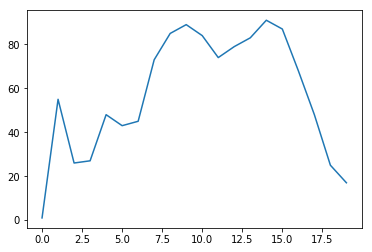

In [76]:
import matplotlib.pyplot as plt
plt.plot(win_list)


In [71]:
import matplot.plot as plt

ModuleNotFoundError: No module named 'matplot'

In [69]:
draw_list

[]

In [163]:
np.arange(9)

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [156]:
a = np.array([[0,0,0,1,0,0,1,1,0]])


In [158]:
allowed = [1,2,3]

In [228]:
a = np.array([[0,0,0,1,0,0,1,1,0]])
p = model.predict(a)
# allowed_action_prob = np.take(p,allowed)
# np.argmax(allowed_action_prob)
p

array([[0.11872599, 0.10063873, 0.10116652, 0.12087925, 0.10957962,
        0.11780806, 0.10732874, 0.11861013, 0.10526288]], dtype=float32)

In [46]:
a = np.array([1,1,0,1,0,0,0,1])

In [47]:
allowed_position = a==1
allowed_action = np.where(allowed_position == True)[0]

In [71]:
np.random.choice(a)

1

In [10]:
board = Env(0)


In [4]:
agent1.get_board()
agent1.step(action=0,mark=0)

[ 0. -1. -1. -1. -1. -1. -1. -1. -1.]


((array([ 0., -1., -1., -1., -1., -1., -1., -1., -1.]),
  [1, 2, 3, 4, 5, 6, 7, 8]),
 0,
 False)

In [5]:
agent1.get_board()

array([[ 0., -1., -1.],
       [-1., -1., -1.],
       [-1., -1., -1.]])

In [7]:
agent2 = Env(1)
# agent2.get_board()
agent2.step(1)
agent1.step(5)
agent2.step(4)
agent1.step(6)
agent2.step(7)

[-1.  1. -1. -1. -1. -1. -1. -1. -1.]
[ 0. -1. -1. -1. -1.  0. -1. -1. -1.]
[-1.  1. -1. -1.  1. -1. -1. -1. -1.]
[ 0. -1. -1. -1. -1.  0.  0. -1. -1.]
[-1.  1. -1. -1.  1. -1. -1.  1. -1.]


((array([-1.,  1., -1., -1.,  1., -1., -1.,  1., -1.]), [0, 2, 3, 5, 6, 8]),
 100,
 True)

In [9]:
agent2.get_board()

array([[-1.,  1., -1.],
       [-1.,  1., -1.],
       [-1.,  1., -1.]])

In [139]:
state, reward, done = agent1.step(8)
print(state)

[-1. -1. -1. -1. -1. -1. -1. -1.  0.]
(array([-1., -1., -1., -1., -1., -1., -1., -1.,  0.]), [0, 1, 2, 3, 4, 5, 6, 7])


In [ ]:
num_episodes = 100

In [145]:
agent1 = Game(0)
agent2 = Game(1)
Q = defaultdict(lambda: np.zeros(env.nA))
plot_every = num_episodes/25
score_collection = []
scores = []
for i_episode in range(1, num_episodes+1):
    episode_reward = 0
    agent0.reset()
    agent1.reset()
    while True:
        play = np.random.choice([True,False],1,p=[0.9,0.1])[0]
        print(play)
        if(play):
            a1_action = np.random.choice(agent1.allowedAction)
            state1, reward1, done = agent1.step(a1_action)
            agent2.set_board(state1[0])
            if(done):
                if(reward1 == 100):
                    print('agent1 won')
                else:
                    print('draw')
                break
            else:
                print('agent1 made a move')
                print(agent1.get_board())


        play = np.random.choice([True,False],1,p=[0.9,0.1])[0]
        if(play):
            a2_action = np.random.choice(agent2.allowedAction)
    #         a2_action = int(input("input a number among "+ str(agent2.allowedAction)))
            state2, reward2, done = agent2.step(a2_action)
            agent1.set_board(state2[0])
            if(done):
                if(reward2 == 100):
                    print('agent2 won')
                else:
                    print('draw')
                break
            else:
                print('agent 2 made a move')
                print(agent2.get_board())


True
[-1. -1. -1. -1.  0. -1. -1. -1. -1.]
agent1 made a move
[[-1. -1. -1.]
 [-1.  0. -1.]
 [-1. -1. -1.]]
[-1. -1. -1. -1.  0. -1. -1. -1.  1.]
agent 2 made a move
[[-1. -1. -1.]
 [-1.  0. -1.]
 [-1. -1.  1.]]
True
[-1. -1. -1. -1.  0.  0. -1. -1.  1.]
agent1 made a move
[[-1. -1. -1.]
 [-1.  0.  0.]
 [-1. -1.  1.]]
[-1.  1. -1. -1.  0.  0. -1. -1.  1.]
agent 2 made a move
[[-1.  1. -1.]
 [-1.  0.  0.]
 [-1. -1.  1.]]
True
[-1.  1. -1. -1.  0.  0. -1.  0.  1.]
agent1 made a move
[[-1.  1. -1.]
 [-1.  0.  0.]
 [-1.  0.  1.]]
[ 1.  1. -1. -1.  0.  0. -1.  0.  1.]
agent 2 made a move
[[ 1.  1. -1.]
 [-1.  0.  0.]
 [-1.  0.  1.]]
True
[ 1.  1.  0. -1.  0.  0. -1.  0.  1.]
agent1 made a move
[[ 1.  1.  0.]
 [-1.  0.  0.]
 [-1.  0.  1.]]
[ 1.  1.  0. -1.  0.  0.  1.  0.  1.]
agent 2 made a move
[[ 1.  1.  0.]
 [-1.  0.  0.]
 [ 1.  0.  1.]]
True
[1. 1. 0. 0. 0. 0. 1. 0. 1.]
agent1 won


In [126]:
def q_learning(env, num_episodes, alpha=0.1, gamma=1.0, epsilon=0.05):
    # initialize action-value function (empty dictionary of arrays)
    Q = defaultdict(lambda: np.zeros(env.nA))
    # initialize performance monitor -
#     Get a0 for s0 based on epsilon
    plot_every = num_episodes/25
    # loop over episodes
    score_collection = []
    scores = []
    for i_episode in range(1, num_episodes+1):
        episode_reward = 0
#         How it acts in each episode
        state = env.reset()
        action = performAction(env,state,Q,epsilon)
        done = False
        steps = 0
        while not done:
            steps+=1
            next_state, reward, done = env.step(action)
            episode_reward += reward
#             list_state = s[1:-1].split(",")
#             if(int(list_state[1])==10 and int(list_state[0])==10):
#             print('\r', 'state: ', state,'i: ', i, end='')
            if not done:
                next_action = performAction(env,next_state,Q,epsilon)
                Q[state][action] = Q[state][action] + (alpha * (reward + (gamma * Q[next_state][next_action]) - Q[state][action]))
                state = next_state
            else:
                Q[state][action] = Q[state][action] + (alpha * (reward + (gamma * Q[next_state][next_action]) - Q[state][action]))
                score_collection.append(episode_reward)
        
        # monitor progress
        if i_episode % 10 == 0:
            scores.append(np.mean(score_collection))
#             print("\rEpisode {}/{}: Reward {}".format(i_episode, num_episodes, episode_reward), end="")
#             sys.stdout.flush()
            print('\r', 'i_episode: ', i_episode, end='')
            score_collection = []
        ## TODO: complete the function
    
    # plot performance
    plt.plot(np.linspace(0,num_episodes,len(scores),endpoint=False),np.asarray(scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(scores))
        
    return Q

3

In [127]:
a = np.array([1,1,1,2,2,2])

In [56]:
list(np.where(a==2)[0])

[3, 4, 5]

In [150]:
play = np.random.choice([True,False],1,p=[0.9,0.1])[0]
play

False